In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from curl_cffi import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import duckdb
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Download historical index prices with error handling
ticker_symbol = '^SPX'
time_start = "2016-11-01"
time_end = "2021-01-08"

# Create a session with browser impersonation
session = requests.Session(impersonate="chrome")

# Inject session into Ticker object
ticker = yf.Ticker(ticker_symbol, session=session)

try:
    data = ticker.history(start=time_start, end=time_end)
    if data.empty:
        raise ValueError("Downloaded data is empty.")
    data.reset_index(inplace=True)
    print(data.head())
except Exception as e:
    print(f"Failed to download data for {ticker_symbol}: {e}")


                       Date         Open         High          Low  \
0 2016-11-01 00:00:00-04:00  2128.679932  2131.449951  2097.850098   
1 2016-11-02 00:00:00-04:00  2109.429932  2111.760010  2094.000000   
2 2016-11-03 00:00:00-04:00  2098.800049  2102.560059  2085.229980   
3 2016-11-04 00:00:00-04:00  2083.790039  2099.070068  2083.790039   
4 2016-11-07 00:00:00-05:00  2100.590088  2132.000000  2100.590088   

         Close      Volume  Dividends  Stock Splits  
0  2111.719971  4539190000        0.0           0.0  
1  2097.939941  4289120000        0.0           0.0  
2  2088.659912  3892100000        0.0           0.0  
3  2085.179932  3841910000        0.0           0.0  
4  2131.520020  3739720000        0.0           0.0  


In [3]:
# Load dataset using KaggleHub
# file_path should match the actual CSV name in the Kaggle dataset
file_path = "tweets.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "codebreaker619/donald-trump-tweets-dataset",
    file_path
)

print("Full dataset shape:", df.shape)

# Use DuckDB to filter the data
query = f"""
    SELECT date, text
    FROM df
    WHERE date >= '{time_start}'
    AND date < '{time_end}'
    ORDER BY date ASC
"""

tweets_df = duckdb.query(query).to_df()

print("Filtered tweets shape:", tweets_df.shape)
tweets_df.head()

100%|██████████| 4.25M/4.25M [00:01<00:00, 3.27MB/s]

Extracting zip of tweets.csv...


Full dataset shape: (56571, 9)
Filtered tweets shape: (26708, 2)


,date,text
0,2016-11-01 10:31:46,Look at the way Crooked Hillary is handling th...
1,2016-11-01 11:55:47,"Wow, now leading in @ABC /@washingtonpost Poll..."
2,2016-11-01 12:01:11,Crooked Hillary should not be allowed to run f...
3,2016-11-01 13:35:47,JOIN ME TOMORROW IN FLORIDA!MIAMI•12pmhttps://...
4,2016-11-01 14:14:09,So terrible that Crooked didn't report she got...


In [4]:
# Define key market-relevant policy verbs (lemmas)
policy_verbs = {
    "raise", "cut", "delay", "increase", "reduce", "ban", "lift", "sign",
    "pause", "cancel", "approve", "block", "tax", "tariff", "subsidize",
    "sanction", "negotiate", "stimulate", "regulate", "boost"
}

# Rule-based detection of Trump-related economic policy flags
def extract_policy_flags(text):
    text = str(text).lower()
    return pd.Series({
        'flag_stimulus': int(any(w in text for w in ['stimulus', 'relief', 'spending', 'package', 'bailout', 'cares act'])),
        'flag_tariff_trade': int(any(w in text for w in ['tariff', 'trade war', 'china', 'import tax', 'mexico', 'deal with china'])),
        'flag_interest_rate': int(any(w in text for w in ['interest rate', 'zero rate', '0%', 'fed', 'cut rates', 'lower rates'])),
        'flag_covid_relief': int(any(w in text for w in ['covid', 'coronavirus', 'pandemic', 'unemployment', 'lockdown', 'shutdown']))
    })

# POS + NER extractor using spaCy
def extract_pos_ner_features(text):
    try:
        doc = nlp(str(text))
        return pd.Series({
            'num_policy_verbs': sum(1 for token in doc if token.pos_ == "VERB" and token.lemma_.lower() in policy_verbs),
            'num_policy_nouns': sum(1 for token in doc if token.pos_ == "NOUN" and token.lemma_.lower() in policy_verbs),
            'num_gpe': sum(1 for ent in doc.ents if ent.label_ == "GPE"),
            'num_percent': sum(1 for ent in doc.ents if ent.label_ == "PERCENT"),
            'num_org': sum(1 for ent in doc.ents if ent.label_ == "ORG"),
            'num_date': sum(1 for ent in doc.ents if ent.label_ == "DATE"),
            'num_money': sum(1 for ent in doc.ents if ent.label_ == "MONEY"),
            'num_law': sum(1 for ent in doc.ents if ent.label_ == "LAW"),
        })
    except:
        return pd.Series([0] * 8, index=[
            'num_policy_verbs', 'num_policy_nouns', 'num_gpe',
            'num_percent', 'num_org', 'num_date', 'num_money', 'num_law'
        ])

# Apply POS/NER features and policy flags to tweets
pos_ner_df = tweets_df['text'].apply(extract_pos_ner_features)
flags_df = tweets_df['text'].apply(extract_policy_flags)

# Combine with tweets_df
tweets_df = pd.concat([tweets_df, pos_ner_df, flags_df], axis=1)

# Optional preview
tweets_df[['date', 'text', 'flag_stimulus', 'flag_tariff_trade', 'flag_interest_rate', 'num_policy_verbs']].sample(5)


,date,text,flag_stimulus,flag_tariff_trade,flag_interest_rate,num_policy_verbs
9168,2019-07-02 22:43:37,https://t.co/hWiNicShLY,0,0,0,0
13057,2019-11-23 15:17:06,Adam Schiff will be compelled to testify shoul...,0,0,0,0
19486,2020-06-05 12:29:45,RT @SenatorEnzi: The unprecedented COVID-19 pa...,0,0,1,0
20941,2020-07-27 13:58:14,RT @MarshaBlackburn: As a member of @SASCMajor...,0,0,0,0
4686,2018-07-29 20:12:15,Is Robert Mueller ever going to release his co...,0,0,0,0


In [5]:
# Ensure tweet 'date' column is datetime.date
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce').dt.date

# Identify all numeric features to aggregate
tweet_feature_cols = [
    col for col in tweets_df.columns
    if col.startswith('sbert_') or
       col.startswith('sentiment_') or
       col.startswith('num_') or
       col.startswith('flag_')
]

# Group and aggregate daily average of tweet features
daily_features = tweets_df.groupby('date')[tweet_feature_cols].mean().reset_index()
daily_features.rename(columns={'date': 'Date'}, inplace=True)

# Preview
print("✅ Daily tweet features aggregated:")
daily_features.head()


✅ Daily tweet features aggregated:


,Date,num_policy_verbs,num_policy_nouns,num_gpe,num_percent,num_org,num_date,num_money,num_law,flag_stimulus,flag_tariff_trade,flag_interest_rate,flag_covid_relief
0,2016-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-11-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-11-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-11-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-11-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Prepare index data with Open, High, Low, Close
index_df = data[['Date', 'Open', 'High', 'Low', 'Close']].copy()
index_df['Date'] = pd.to_datetime(index_df['Date']).dt.date

# Merge with tweet-based daily features
daily_features['Date'] = pd.to_datetime(daily_features['Date']).dt.date
merged_df = pd.merge(index_df, daily_features, on='Date', how='inner')

# Define 5-day-ahead target price
merged_df['target_price'] = merged_df['Close'].shift(-5)

# Define 5-day-ahead return from today's open
merged_df['target_return'] = (merged_df['target_price'] - merged_df['Open']) / merged_df['Open']

# Calculate actual intraday returns (same-day only, not 5-day ahead)
merged_df['return_high'] = (merged_df['High'] - merged_df['Open']) / merged_df['Open']
merged_df['return_low'] = (merged_df['Low'] - merged_df['Open']) / merged_df['Open']
merged_df['return_close'] = (merged_df['Close'] - merged_df['Open']) / merged_df['Open']

# Drop rows with missing target
merged_df.dropna(subset=['target_price', 'target_return'], inplace=True)

# Preview
merged_df[['Date', 'Open', 'High', 'Low', 'Close', 'target_price', 'target_return', 'return_high', 'return_low', 'return_close']].head()


,Date,Open,High,Low,Close,target_price,target_return,return_high,return_low,return_close
0,2016-11-01,2128.679932,2131.449951,2097.850098,2111.719971,2139.560059,0.005111,0.001301,-0.014483,-0.007967
1,2016-11-02,2109.429932,2111.760010,2094.000000,2097.939941,2163.260010,0.025519,0.001105,-0.007315,-0.005447
2,2016-11-03,2098.800049,2102.560059,2085.229980,2088.659912,2167.479980,0.032723,0.001792,-0.006466,-0.004831
3,2016-11-04,2083.790039,2099.070068,2083.790039,2085.179932,2164.449951,0.038708,0.007333,0.000000,0.000667
4,2016-11-07,2100.590088,2132.000000,2100.590088,2131.520020,2180.389893,0.037989,0.014953,0.000000,0.014724


In [7]:
# Define input sequence length (e.g., 5 days of history)
sequence_length = 5

# Optional: explicitly exclude non-input columns
exclude_cols = ['Date', 'Close', 'target_price', 'target_return',
                'return_high', 'return_low', 'return_close']
feature_cols = [col for col in merged_df.columns if col not in exclude_cols]


X, y = [], []

# Rolling window over data to build sequences
for i in range(len(merged_df) - sequence_length):
    seq_X = merged_df[feature_cols].iloc[i:i + sequence_length].values
    seq_y = merged_df['target_return'].iloc[i + sequence_length]  # or use 'target_price'
    X.append(seq_X)
    y.append(seq_y)

X = np.array(X)
y = np.array(y)

print("✅ LSTM input ready:")
print("X shape:", X.shape)  # (samples, sequence_length, features)
print("y shape:", y.shape)


✅ LSTM input ready:
X shape: (1036, 5, 15)
y shape: (1036,)


In [8]:
# Flatten X to 2D for scaling
n_samples, n_steps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)

# Scale inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(n_samples, n_steps, n_features)

# Scale target (return)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("✅ Normalized input ready for training.")
print("X_scaled shape:", X_scaled.shape, "| y_scaled shape:", y_scaled.shape)


✅ Normalized input ready for training.
X_scaled shape: (1036, 5, 15) | y_scaled shape: (1036,)


In [9]:
# Train-test split (no shuffling, to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Define LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train
history = model.fit(X_train, y_train, epochs=255, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4462 - mae: 0.4746 - val_loss: 0.9985 - val_mae: 0.6277
Epoch 2/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4761 - mae: 0.4774 - val_loss: 0.9672 - val_mae: 0.6500
Epoch 3/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4863 - mae: 0.4835 - val_loss: 0.9500 - val_mae: 0.6626
Epoch 4/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4547 - mae: 0.4701 - val_loss: 0.9447 - val_mae: 0.6751
Epoch 5/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4607 - mae: 0.4827 - val_loss: 0.9383 - val_mae: 0.6950
Epoch 6/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4237 - mae: 0.4610 - val_loss: 0.9791 - val_mae: 0.7530
Epoch 7/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4825 - mae: 0.4886 - val_loss: 0.9361 - val_mae: 0.7248
Epoch 8/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4808 - mae: 0.4740 - val_loss: 0.9487 - val_mae: 0.7487
Epoch 9/255
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
✅ Evaluation:
MAE: 0.03774 | RMSE: 0.04778 | R²: -0.3317


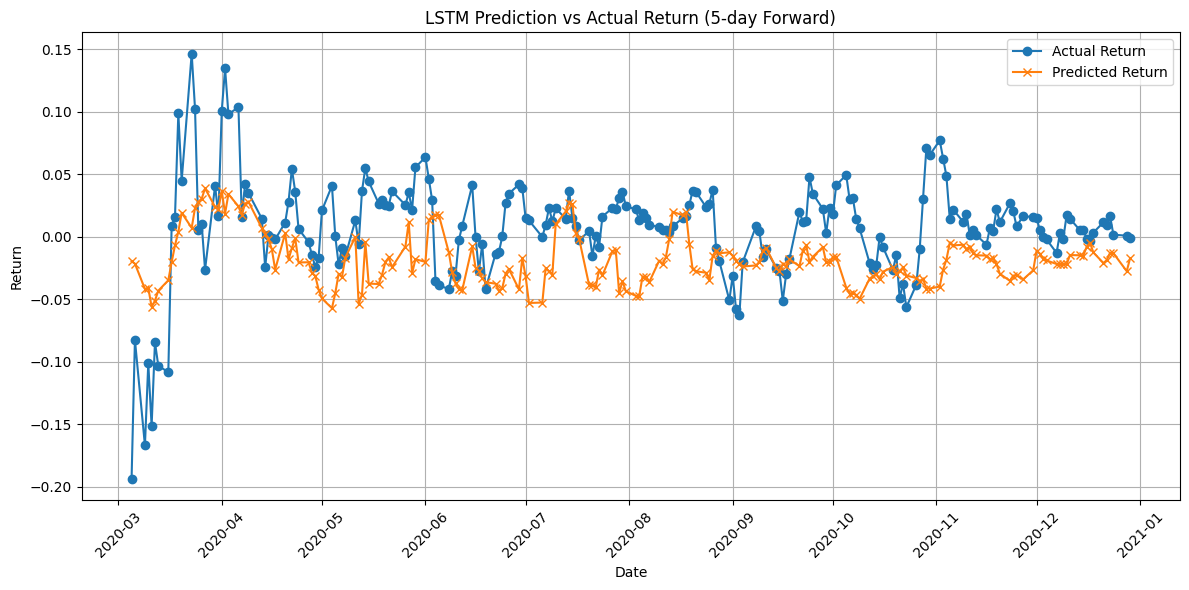

In [10]:
# Predict on test set
y_pred_scaled = model.predict(X_test).flatten()

# Inverse scale predictions and targets
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print(f"✅ Evaluation:\nMAE: {mae:.5f} | RMSE: {rmse:.5f} | R²: {r2:.4f}")

# Match test dates to prediction length
test_dates = merged_df['Date'].iloc[-len(y_test_actual):]

# Plot predicted vs actual return
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual Return', marker='o')
plt.plot(test_dates, y_pred, label='Predicted Return', marker='x')
plt.title('LSTM Prediction vs Actual Return (5-day Forward)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Get test dates and OHLC data from merged_df
test_dates = merged_df['Date'].iloc[-len(y_pred):].reset_index(drop=True)
daily_open  = merged_df['Open'].iloc[-len(y_pred):].values
daily_high  = merged_df['High'].iloc[-len(y_pred):].values
daily_low   = merged_df['Low'].iloc[-len(y_pred):].values
daily_close = merged_df['Close'].iloc[-len(y_pred):].values

# Calculate model prediction as a price level
predicted_price = daily_open * (1 + y_pred)

# Actual intraday return
actual_return_close = (daily_close - daily_open) / daily_open
actual_direction = np.sign(actual_return_close)
predicted_direction = np.sign(y_pred)

# Build analysis DataFrame
analysis_df = pd.DataFrame({
    'Date': test_dates,
    'Open': daily_open,
    'High': daily_high,
    'Low': daily_low,
    'Close': daily_close,
    'Predicted Return': y_pred,
    'Predicted Price': predicted_price,
    'Actual Return (Close)': actual_return_close,
    'Predicted Direction': predicted_direction,
    'Actual Direction': actual_direction
})

# Add trade action (buy/sell) and trade outcome flags
analysis_df['Trade Action'] = analysis_df['Predicted Return'].apply(
    lambda r: 'Buy' if r > 0.001 else ('Sell' if r < -0.001 else 'No Trade')
)

# Hit logic: was the predicted price reachable?
analysis_df['Hit (Reached Target)'] = (
    ((analysis_df['Trade Action'] == 'Buy') & (analysis_df['High'] >= analysis_df['Predicted Price'])) |
    ((analysis_df['Trade Action'] == 'Sell') & (analysis_df['Low']  <= analysis_df['Predicted Price']))
)

# Direction match logic
analysis_df['Direction Match'] = analysis_df['Predicted Direction'] == analysis_df['Actual Direction']

# Add Trump tweets
tweets_subset = tweets_df[tweets_df['date'].isin(test_dates)]
tweets_grouped = tweets_subset.groupby('date')['text'].apply(lambda texts: ' | '.join(texts)).reset_index()
tweets_grouped.rename(columns={'date': 'Date', 'text': 'Trump Tweets'}, inplace=True)

# Merge into final analysis
analysis_df = pd.merge(analysis_df, tweets_grouped, on='Date', how='left')

# Optional: tidy column order
ordered_cols = [
    'Date', 'Open', 'High', 'Low', 'Close',
    'Predicted Return', 'Predicted Price', 'Trade Action',
    'Hit (Reached Target)', 'Direction Match', 'Actual Return (Close)',
    'Trump Tweets'
]
analysis_df = analysis_df[ordered_cols]

# Display first few rows
pd.set_option('display.max_colwidth', 200)
analysis_df.head(10)


,Date,Open,High,Low,Close,Predicted Return,Predicted Price,Trade Action,Hit (Reached Target),Direction Match,Actual Return (Close),Trump Tweets
0,2020-03-05,3075.699951,3083.040039,2999.830078,3023.939941,-0.019458,3015.854277,Sell,True,True,-0.016829,"RT @realDonaldTrump: Thank you, keep up the great work! | RT @realDonaldTrump: Congress has agreed to provide $8 Billion to fight Coronavirus! This means @CDCgov, @HHSGov, and @DHSgov will have th..."
1,2020-03-06,2954.199951,2985.929932,2901.540039,2972.370117,-0.021367,2891.078401,Sell,False,False,0.006151,"Tonight’s Fox News Town Hall with @MarthaMacCallum and @BretBaier will rebroadcast at 11:00 P.M. Eastern on @FoxNews. Enjoy! | Thank you Scranton, Pennsylvania. It was a great evening! https://t.c..."
2,2020-03-09,2863.889893,2863.889893,2734.429932,2746.560059,-0.041648,2744.615202,Sell,True,True,-0.040969,"RT @thedailybeast: Surgeon General Jerome Adams used his comments to downplay the risk of coronavirus to the president https://t.co/PA6a3Dv… | There are no mixed messages, only political weaponiza..."
3,2020-03-10,2813.479980,2882.590088,2734.000000,2882.229980,-0.040817,2698.642776,Sell,False,False,0.024436,"Oklahoma, Vote for your GREAT Senator Today. Nobody better than Jim! https://t.co/nYoLaM5Peu | RT @alx: .@trish_regan didn’t say Coronavirus is a scam.. she’s talking about how Democrats are blami..."
4,2020-03-11,2825.600098,2825.600098,2707.219971,2741.379883,-0.055851,2667.788566,Sell,False,True,-0.029806,THANK YOU MISSISSIPPI! #KAG2020 https://t.co/r4DRnssHya | THANK YOU MISSOURI! #KAG2020 https://t.co/FH7NcIPqDp | THANK YOU MICHIGAN! #KAG2020 https://t.co/9Ibuma0JfP | Tommy Tuberville (@TTubervil...
5,2020-03-12,2630.860107,2660.949951,2478.860107,2480.639893,-0.050955,2496.803539,Sell,True,True,-0.057099,"https://t.co/YioC9eARdP | Hoping to get the payroll tax cut approved by both Republicans and Democrats, and please remember, very important for all countries &amp; businesses to know that trade wi..."
6,2020-03-13,2569.989990,2711.330078,2492.370117,2711.020020,-0.043028,2459.408928,Sell,False,False,0.054876,RT @BW: This German biotech company has made kits with 4 million coronavirus tests since the outbreak began https://t.co/KQczW0srBr | RT @PrincessCruises: We have always been dedicated to one trut...
7,2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,-0.034642,2421.688006,Sell,True,True,-0.048816,"RT @SaraCarterDC: Absolutely @realDonaldTrump ! This has been such an injustice to Gen. Flynn, his family and the American people - the o… | RT @SaraCarterDC: Not a criminal like those who tried..."
8,2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,-0.020188,2376.689596,Sell,True,False,0.042681,RT @LindseyGrahamSC: My primary goal is to lessen the loss of life. \n\nOur economy can be rebuilt. The loss of life is permanent. \n\nI appr… | Great news Lindsey! https://t.co/Fn8C7IoZaF | RT ...
9,2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,-0.006740,2420.078344,Sell,True,True,-0.015760,"RT @AjitPaiFCC: In wake of #Covid_19 outbreak, telework, remote learning, and telehealth are key. We must ensure that Americans don't lose… | RT @WhiteHouse: What is social distancing—and why are ..."


In [12]:
# Reconstruct predicted price from return
y_pred_price = merged_df['Open'].iloc[-len(y_pred):].values * (1 + y_pred)
y_actual_price = merged_df['target_price'].iloc[-len(y_pred):].values

# Rebuild original high series for future 5-day window
high_5d_max = []

for i in range(len(merged_df) - len(y_pred), len(merged_df)):
    high_window = data['High'].iloc[i:i+5]
    high_5d_max.append(high_window.max())

high_5d_max = np.array(high_5d_max)


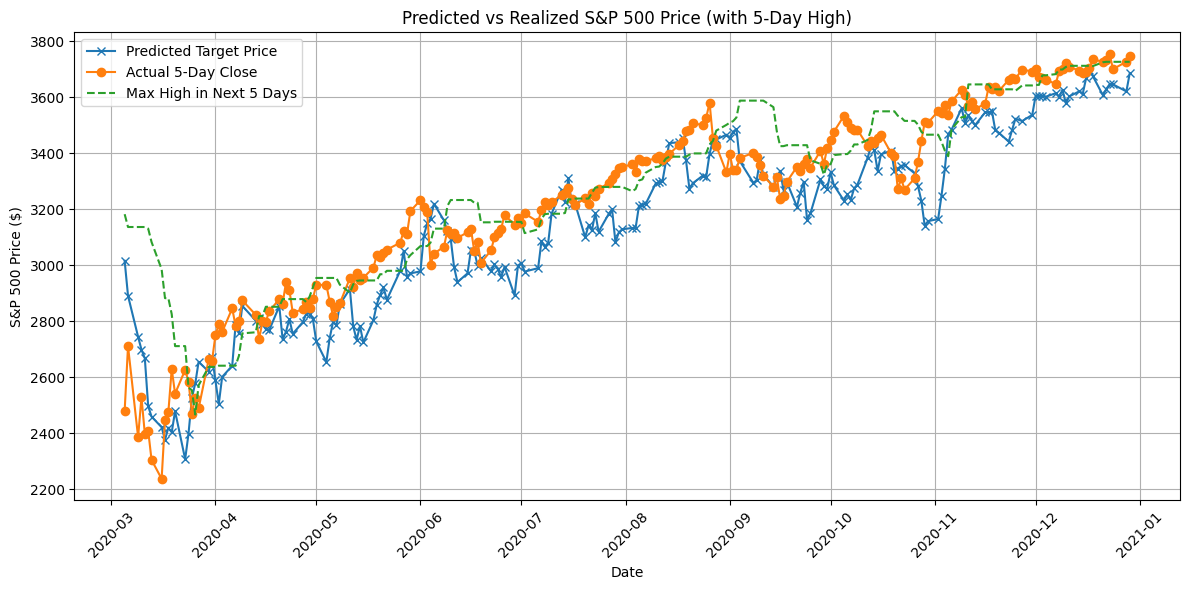

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_pred_price, label='Predicted Target Price', marker='x')
plt.plot(test_dates, y_actual_price, label='Actual 5-Day Close', marker='o')
plt.plot(test_dates, high_5d_max, label='Max High in Next 5 Days', linestyle='--')

plt.title('Predicted vs Realized S&P 500 Price (with 5-Day High)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Price ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


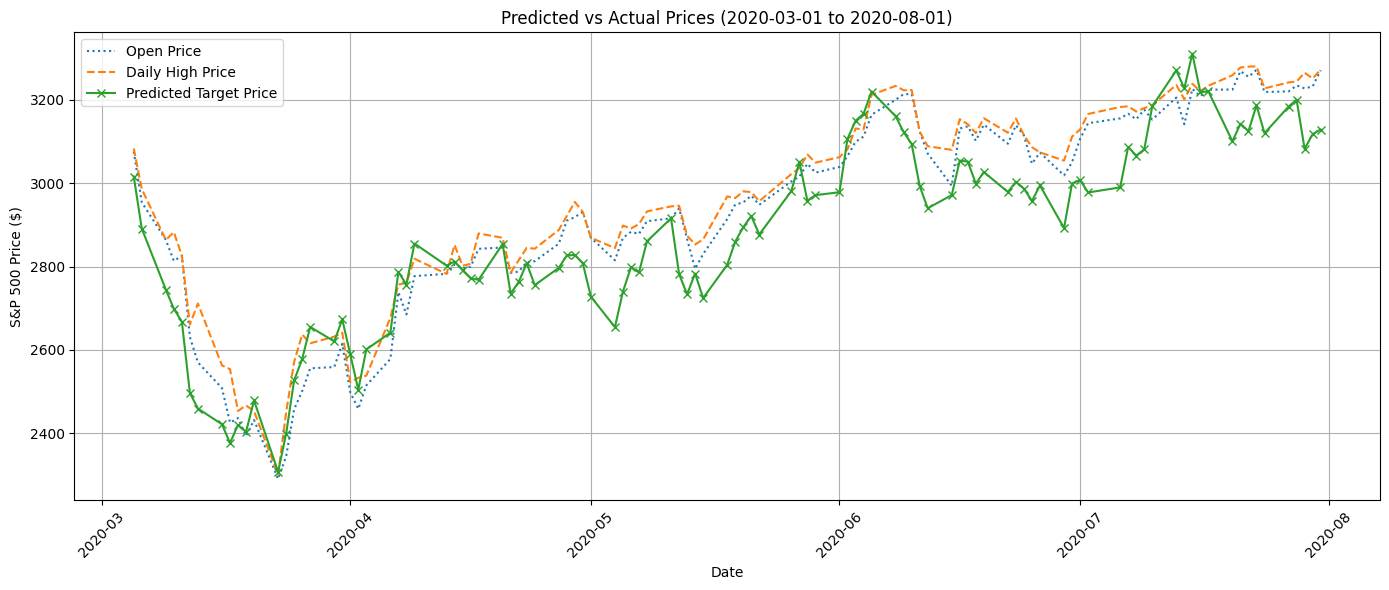

In [14]:
# Reconstruct predicted price from predicted return
y_pred_price = merged_df['Open'].iloc[-len(y_pred):].values * (1 + y_pred)
daily_high = merged_df['High'].iloc[-len(y_pred):].values
daily_open = merged_df['Open'].iloc[-len(y_pred):].values
test_dates = merged_df['Date'].iloc[-len(y_pred):]

# Create DataFrame
plot_df = pd.DataFrame({
    'Date': test_dates,
    'Open': daily_open,
    'High': daily_high,
    'Predicted_Price': y_pred_price
})

# Filter to a specific time window (e.g., 2020 Q2)
start_date = pd.to_datetime("2020-03-01").date()
end_date   = pd.to_datetime("2020-08-01").date()
plot_df = plot_df[(plot_df['Date'] >= start_date) & (plot_df['Date'] <= end_date)]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(plot_df['Date'], plot_df['Open'], label='Open Price', linestyle=':')
plt.plot(plot_df['Date'], plot_df['High'], label='Daily High Price', linestyle='--')
plt.plot(plot_df['Date'], plot_df['Predicted_Price'], label='Predicted Target Price', marker='x')

plt.title(f'Predicted vs Actual Prices ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('S&P 500 Price ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
